# Fashion MNIST - algorithm explainability

In [6]:
# The following two cells improve the formatting of the notebook

In [7]:
# Increase notebook cell width. Cell below increases the height.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [8]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [9]:
# General libraries
import lime
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [36]:
# Classifier libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [11]:
# Preprocessors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Raw data

In [12]:
%%bash
ls -l data/

total 151604
-rw-rw---- 1 root everybody  22176691 Aug  2 23:39 fashion-mnist_test.csv
-rw-rw---- 1 root everybody 133047193 Aug  2 23:40 fashion-mnist_train.csv


In [13]:
# Import train and test datasets
df_train = df_train = pd.read_csv("data/fashion-mnist_train.csv")
df_test = pd.read_csv("data/fashion-mnist_test.csv")

### Size and shape of data

In [14]:
print("df_train.shape:", df_train.shape)
print("df_test.shape:", df_test.shape)

df_train.shape: (60000, 785)
df_test.shape: (10000, 785)


In [15]:
# Convert data to numpy arrays for modeling
X_train = df_train.iloc[:, 1:].as_matrix()
y_train = df_train["label"].as_matrix()
X_test = df_test.iloc[:, 1:].as_matrix()
y_test = df_test["label"].as_matrix()

In [16]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


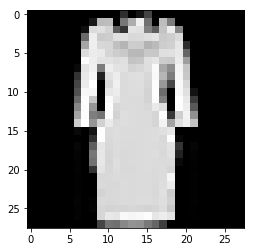

In [79]:
# Display a digit
pixels =  np.array(df_train.iloc[4][1:]).reshape((28,28))
plt.imshow(pixels, cmap="gray")

In [77]:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

### Train and test distributions

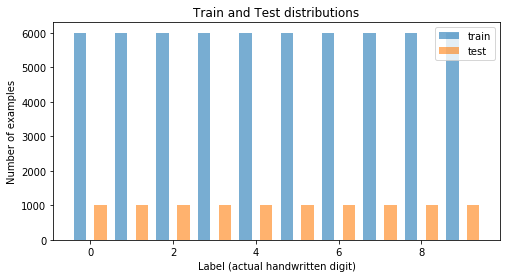

In [17]:
fig = plt.figure(figsize=(8, 4))
plt.bar(left=df_train["label"].value_counts().index-0.25,
           height=df_train["label"].value_counts().values,
          alpha=0.6,
          # align="center",
          width=0.3,
       label="train")
plt.bar(left=df_test["label"].value_counts().index+0.25,
           height=df_test["label"].value_counts().values,
          alpha=0.6,
          # align="center",
          width=0.3,
       label="test")
plt.legend()
plt.xlabel("Label (actual handwritten digit)")
plt.ylabel("Number of examples")
plt.title("Train and Test distributions")
plt.show() # avoids some annoying text in the output cell, despite %matplotlib inline

## Baseline classifiers

### Random Forest

In [40]:
clf = RandomForestClassifier(random_state=42)

In [41]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [42]:
baseline_accuracy = clf.score(X_test, y_test)
print("Baseline accuracy: %.2f%%" % (baseline_accuracy*100))

Baseline accuracy: 86.39%


### K-nearest Neighbors (with PCA)

In [21]:
clf = KNeighborsClassifier(n_jobs=-1)

In [22]:
# Apply PCA to reduce number of features
pca = PCA(n_components=100) # use 100 principal components
X_train_pca = pca.fit_transform(X_train) # convert X_train in 100 principal components

In [23]:
clf.fit(X_train_pca, y_train) # fit model using 100 principal components

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
# Convert X_test into 100 principal components
X_test_pca = pca.transform(X_test)

In [25]:
baseline_accuracy = clf.score(X_test_pca, y_test)
print("Baseline accuracy: %.2f%%" % (baseline_accuracy*100))

Baseline accuracy: 85.94%


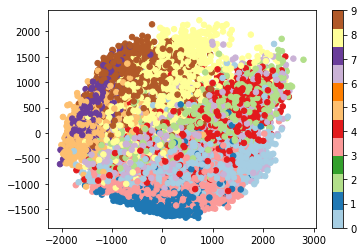

In [26]:
x_plot = X_test_pca[:, 0]
y_plot = X_test_pca[:, 1]
labels = y_test

# plt.figure(figsize=(8, 6))

# use plt.cm.get_cmap(cmap, N) to get an N-bin version of cmap
plt.scatter(x_plot, y_plot, s=30,
            c=labels, cmap=plt.cm.get_cmap("Paired"))

plt.colorbar()

### GaussianNB

In [37]:
clf = GaussianNB()

In [38]:
clf.fit(X_train, y_train)

GaussianNB(priors=None)

In [39]:
baseline_accuracy = clf.score(X_test, y_test)
print("Baseline accuracy: %.2f%%" % (baseline_accuracy*100))

Baseline accuracy: 59.14%


## Pipeline components

### Helper functions

In [ ]:
# Function to execute all pipeline steps
def execute_pipeline(pipeline):
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)
    mean_acc = pipeline.score(X_test, y_test)
    algo = list(pipeline.get_params().values())[1][1][0] # name of the algo
    preproc = list(pipeline.get_params().values())[1][0][0] # name of the preprocessing method
    return prediction, mean_acc, algo, preproc

In [ ]:
# Function to create scatter plot of test results
def plot_test_results_scatter(results, pipeline_name="Enter pipeline name"):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(results[0], y_test,alpha=0.01, s=100)
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    ax.set_title("Pipeline name: %s\nAlgo: %s, Preprocessing: %s\nMean accuracy: %.2f%%" % (pipeline_name,
                                                                                            results[2],
                                                                                            results[3],
                                                                                            (results[1]*100)))
    ax.grid()

### Preprocessors

#### PCA without standard scaling

In [ ]:
pca = PCA()

In [ ]:
pca.fit(X_train)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(list(range(X_train.shape[1])), pca.explained_variance_ratio_.cumsum())
ax.set_xlabel("No. of principal components")
ax.set_ylabel("Explained variance")
ax.set_title("PCA")
ax.grid()

In [ ]:
print("Without standard scaling the first 100 pricipal components explain %.1f%% of the variance." % (sum(pca.explained_variance_ratio_[:100])*100))
print("Without standard scaling the first 200 pricipal components explain %.1f%% of the variance." % (sum(pca.explained_variance_ratio_[:200])*100))

## Generate results

In [ ]:
# Create container to store results of each pipeline
accs = {}

In [ ]:
accs

In [ ]:
results_table = pd.DataFrame.from_dict(accs, orient="index", columns=["accuracy"])
results_table

In [ ]:
# Plot results
plot_test_results_scatter(p1_results, pipeline_name="pipeline1")